In [14]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,ResNet101
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Paths to image directoriesz
glioma_tumor_dir = 'Training/glioma_tumor'
meningioma_tumor_dir = 'Training/meningioma_tumor'
normal_dir = 'Training/no_tumor'
pituitary_tumor_dir = 'Training/pituitary_tumor'

In [15]:
working_dir = 'brain-tumor-dataset/working'
train_dir = os.path.join(working_dir, 'train')
val_dir = os.path.join(working_dir, 'val')

In [4]:

def display_sample_images(image_dir, title, num_samples=5):
    plt.figure(figsize=(12, 4))
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)[:num_samples]]
    for i, image_path in enumerate(image_paths):
        img = mpimg.imread(image_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()


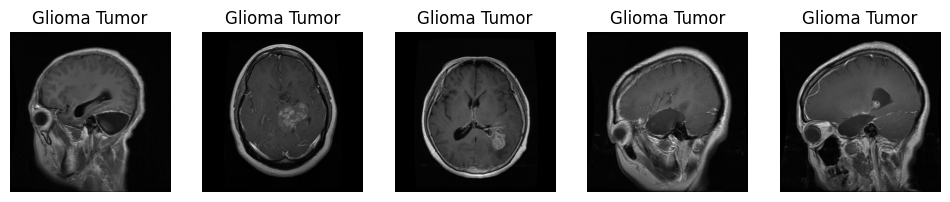

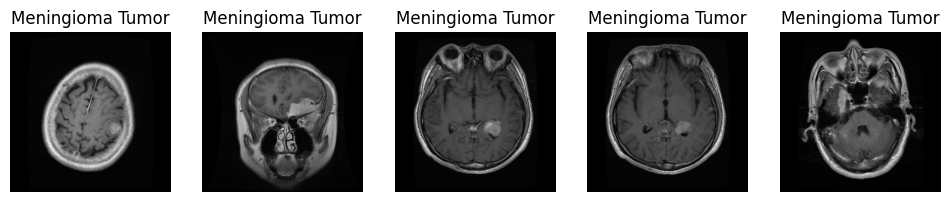

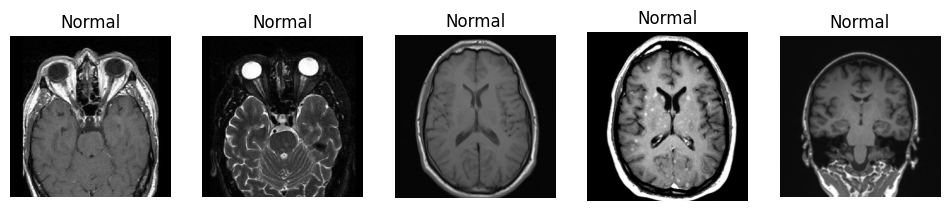

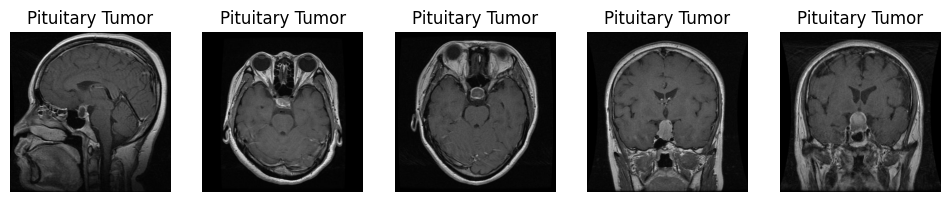

In [5]:

display_sample_images(glioma_tumor_dir, 'Glioma Tumor')
display_sample_images(meningioma_tumor_dir, 'Meningioma Tumor')
display_sample_images(normal_dir, 'Normal')
display_sample_images(pituitary_tumor_dir, 'Pituitary Tumor')

In [6]:
def get_image_count(image_dir):
    return len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])

glioma_count = get_image_count(glioma_tumor_dir)
meningioma_count = get_image_count(meningioma_tumor_dir)
normal_count = get_image_count(normal_dir)
pituitary_count = get_image_count(pituitary_tumor_dir)


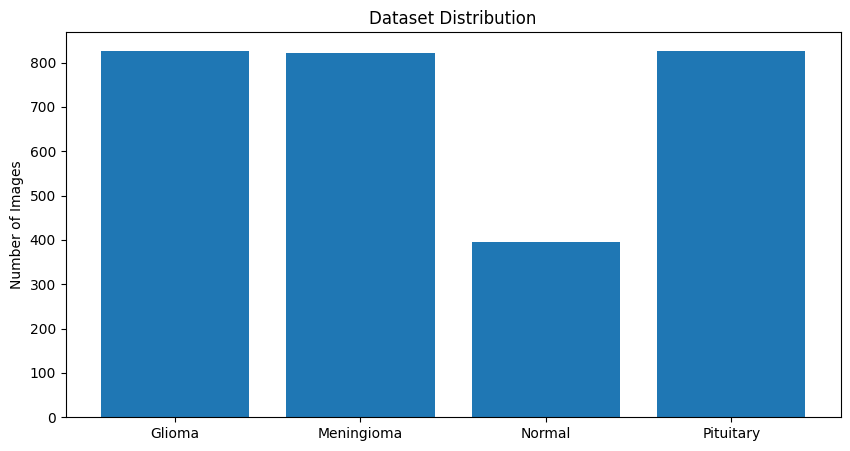

In [7]:
plt.figure(figsize=(10, 5))
plt.bar(['Glioma', 'Meningioma', 'Normal', 'Pituitary'], [glioma_count, meningioma_count, normal_count, pituitary_count])
plt.ylabel('Number of Images')
plt.title('Dataset Distribution')
plt.show()

In [8]:
def get_image_paths(directory_path):
    image_paths = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

def organize_data(image_paths, label, train_dir, val_dir, test_size=0.2):
    train_paths, val_paths = train_test_split(image_paths, test_size=test_size, random_state=42)
    def copy_images(paths, dest_dir):
        os.makedirs(dest_dir, exist_ok=True)
        for path in paths:
            shutil.copy(path, os.path.join(dest_dir, os.path.basename(path)))
    train_label_dir = os.path.join(train_dir, label)
    val_label_dir = os.path.join(val_dir, label)
    copy_images(train_paths, train_label_dir)
    copy_images(val_paths, val_label_dir)
    return len(train_paths), len(val_paths)

In [9]:
# Get image paths
glioma_image_paths = get_image_paths(glioma_tumor_dir)
meningioma_image_paths = get_image_paths(meningioma_tumor_dir)
normal_image_paths = get_image_paths(normal_dir)
pituitary_image_paths = get_image_paths(pituitary_tumor_dir)

# Organize data
num_train_glioma, num_val_glioma = organize_data(glioma_image_paths, 'glioma_tumor', train_dir, val_dir)
num_train_meningioma, num_val_meningioma = organize_data(meningioma_image_paths, 'meningioma_tumor', train_dir, val_dir)
num_train_normal, num_val_normal = organize_data(normal_image_paths, 'normal', train_dir, val_dir)
num_train_pituitary, num_val_pituitary = organize_data(pituitary_image_paths, 'pituitary_tumor', train_dir, val_dir)


In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2294 images belonging to 4 classes.
Found 576 images belonging to 4 classes.


In [ ]:
model = models.Sequential()
model.add(ResNet101(include_top=False, weights='imagenet', pooling='avg'))
model.add(layers.Dense(4, activation='softmax'))

for layer in model.layers[0].layers:
    layer.trainable = False
    
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the trained model
model_save_path = "resnet101_trained_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


2024-12-08 14:33:09.812119: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/mnt/845A70CE5A70BF0C/btp/resnet101/btp/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.5614 - loss: 1.0940 - val_accuracy: 0.7812 - val_loss: 0.5721
Epoch 2/15
 1/71 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.8125 - loss: 0.4923

/mnt/845A70CE5A70BF0C/btp/resnet101/btp/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - accuracy: 0.8125 - loss: 0.4923 - val_accuracy: 0.7656 - val_loss: 0.5838
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7978 - loss: 0.5546 - val_accuracy: 0.8125 - val_loss: 0.4728
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 444ms/step - accuracy: 0.8125 - loss: 0.4239 - val_accuracy: 0.8385 - val_loss: 0.4501
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8149 - loss: 0.4834 - val_accuracy: 0.8420 - val_loss: 0.4353
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 447ms/step - accuracy: 0.7500 - loss: 0.5648 - val_accuracy: 0.8351 - val_loss: 0.4438
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8488 - loss: 0.4030 - val_accuracy: 0.8247 - val_loss: 0.4442
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - accuracy: 0.8125 - loss: 0.6988 - val_accuracy: 0.8333 - val_loss: 0.4259
Epoch 9/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8613 - loss: 0.3635 - val_accuracy: 0.8767 - val_

Model saved to resnet101_trained_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8821 - loss: 0.3414
Validation Accuracy: 0.8784722089767456


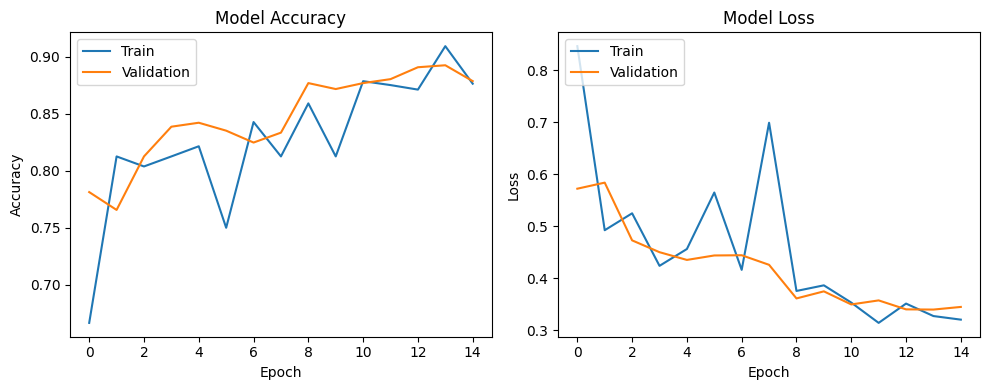

In [12]:
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print("Validation Accuracy: {}".format(val_accuracy))

# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 2048)           │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,682,766 (162.82 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 42,658,176 (162.73 MB)

 Optimizer params: 16,394 (64.04 KB)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

y_true = validation_generator.classes 
y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
y_pred = np.argmax(y_pred, axis=1)  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the results
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix: \n", conf_matrix)


Epoch 1/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5113 - loss: 1.1427 - val_accuracy: 0.7934 - val_loss: 0.5469
Epoch 2/15
 1/71 ━━━━━━━━━━━━━━━━━━━━ 1:06 946ms/step - accuracy: 0.5625 - loss: 0.7611

/mnt/845A70CE5A70BF0C/btp/resnet101/btp/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.5625 - loss: 0.7611 - val_accuracy: 0.7760 - val_loss: 0.5584
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8017 - loss: 0.5320 - val_accuracy: 0.8247 - val_loss: 0.4635
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.8438 - loss: 0.4058 - val_accuracy: 0.8247 - val_loss: 0.4773
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8366 - loss: 0.4537 - val_accuracy: 0.8333 - val_loss: 0.4299
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.9375 - loss: 0.3427 - val_accuracy: 0.8490 - val_loss: 0.4225
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8584 - loss: 0.3935 - val_accuracy: 0.8750 - val_loss: 0.3777
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.8750 - loss: 0.4105 - val_accuracy: 0.8611 - val_loss: 0.3958
Epoch 9/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8613 - loss: 0.3685 - val_accuracy: 0.7934 - val_loss

ResNet50 Model saved to resnet50_brain_tumor_model.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 979ms/step - accuracy: 0.8670 - loss: 0.3832
ResNet50 Validation Accuracy: 85.76%


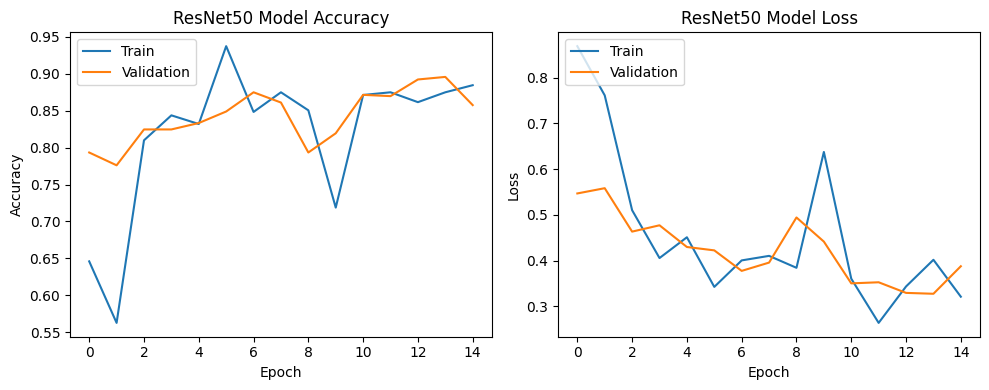

In [16]:
# Build model using ResNet50
base_model_resnet50 = ResNet50(include_top=False, weights='imagenet', pooling='avg')

model_resnet50 = models.Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(layers.Dense(4, activation='softmax'))  # 4 classes

# Freeze ResNet50 layers
for layer in base_model_resnet50.layers:
    layer.trainable = False

# Compile the model
model_resnet50.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet50 = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the trained model
model_save_path_resnet50 = "resnet50_brain_tumor_model.h5"
model_resnet50.save(model_save_path_resnet50)
print(f"ResNet50 Model saved to {model_save_path_resnet50}")

# Evaluate the model
val_loss_resnet50, val_accuracy_resnet50 = model_resnet50.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print("ResNet50 Validation Accuracy: {:.2f}%".format(val_accuracy_resnet50 * 100))

# Plot training & validation accuracy and loss for ResNet50
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [18]:
base_model_resnet50.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
model_resnet50.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,302 (90.07 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,394 (64.04 KB)

In [1]:

history_50 = history_resnet50
history_101 = history

# Plot Training & Validation Accuracy Comparison
plt.figure(figsize=(12, 5))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(history_50.history['accuracy'], label='ResNet-50 Train Accuracy', color='blue')
plt.plot(history_50.history['val_accuracy'], label='ResNet-50 Val Accuracy', color='blue', linestyle='--')
plt.plot(history_101.history['accuracy'], label='ResNet-101 Train Accuracy', color='orange')
plt.plot(history_101.history['val_accuracy'], label='ResNet-101 Val Accuracy', color='orange', linestyle='--')
plt.title('ResNet-50 vs ResNet-101 - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(history_50.history['loss'], label='ResNet-50 Train Loss', color='blue')
plt.plot(history_50.history['val_loss'], label='ResNet-50 Val Loss', color='blue', linestyle='--')
plt.plot(history_101.history['loss'], label='ResNet-101 Train Loss', color='orange')
plt.plot(history_101.history['val_loss'], label='ResNet-101 Val Loss', color='orange', linestyle='--')
plt.title('ResNet-50 vs ResNet-101 - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the graphs
plt.tight_layout()
plt.show()


NameError: name 'history_resnet50' is not defined